In [1]:
import torch
from copy import deepcopy
import numpy as np

from optim import SD, LBFGS, BFGS, DFP
from models import Rosen
from utils import plot_log_loss_curve

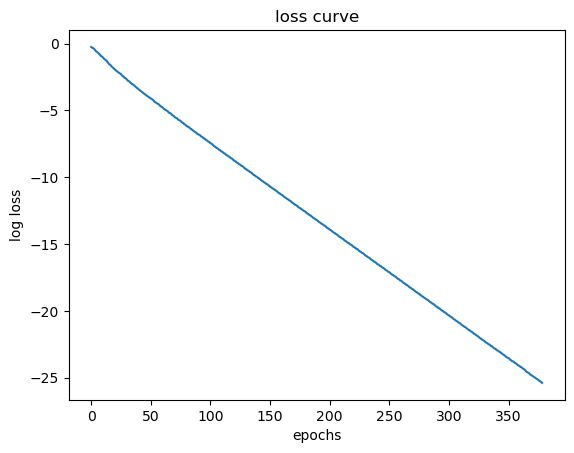

In [15]:
# Backtracking line search
def backtrack_linesearch_f(f, gk, pk, xk, alpha=0.1, beta=0.8):
    t = 1
    # check admissibility condition
    while f(xk + t * pk) > f(xk) + alpha * t * gk.T @ pk:
        t *= beta
    return t

# steepest descent with backtracking line search
def steepest_descent_bt(f, grad, x0, tol=1e-5, log=True):
    x = x0
    history = []
    while (torch.norm(grad(x))>tol):
        p = -1 * grad(x)
        t = backtrack_linesearch_f(f, grad(x), p, x)
        x = x + t*p
        
        if log:
            print(torch.norm(grad(x)) > tol)
            print(torch.norm(grad(x)), tol)
            print("--------")
        history.append(x.clone())

    return x, history


device = 'cpu'
model = Rosen(device)

def f(x):
    x, y = x[0], x[1]
    model.set_params((x, y))
    loss = model.loss(None, None, None)
    return loss

def grad(x):
    x_ = x.clone()
    x, y = x[0], x[1]
    model.set_params((x, y))
    loss = model.loss(None, None, None)
    grad_x, grad_y = model.gradient()
    return torch.cat([grad_x.flatten(), grad_y.flatten()]).reshape_as(x_)

x0 = torch.randn(2,1).requires_grad_(True).to(device)
x, history = steepest_descent_bt(f, grad, x0, log=False)
loss = []
for i in range(len(history)):
    loss.append(f(history[i]).item())
plot_log_loss_curve(np.array(loss))

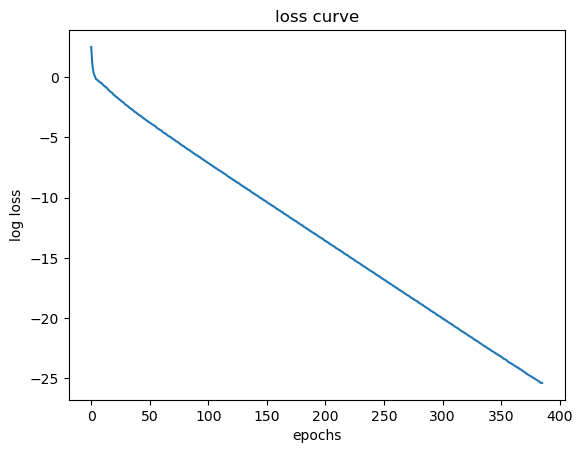

In [17]:
# steepest descent with backtracking line search
class SD():
    
    def __init__(self, f, grad, tol=1e-5, log=True):
        self.f = f
        self.grad = grad
        self.tol = tol
        self.log = log
        self.early_stop = False
    
    def step(self, x):
        if torch.norm(self.grad(x)) < self.tol:
            self.early_stop = True
        else:
            p = -1 * self.grad(x)
            t = backtrack_linesearch_f(self.f, self.grad(x), p, x)
            x = x + t*p
            if self.log:
                print(torch.norm(grad(x)) > self.tol)
                print(torch.norm(grad(x)), self.tol)
                print("--------")
        loss = self.f(x)
        return x, loss.item()


device = 'cpu'
num_epochs = 1000
model = Rosen(device)

def f(x):
    x, y = x[0], x[1]
    model.set_params((x, y))
    loss = model.loss(None, None, None)
    return loss

def grad(x):
    x_ = x.clone()
    x, y = x[0], x[1]
    model.set_params((x, y))
    loss = model.loss(None, None, None)
    grad_x, grad_y = model.gradient()
    return torch.cat([grad_x.flatten(), grad_y.flatten()]).reshape_as(x_)

optimizer = SD(f, grad, tol=1e-5, log=False)
x = torch.randn(2,1).requires_grad_(True).to(device)
loss_list = []
for epoch in range(num_epochs):
    x, loss = optimizer.step(x)
    loss_list.append(loss)
    if optimizer.early_stop:
        break
plot_log_loss_curve(np.array(loss_list))